<a href="https://colab.research.google.com/github/kiseonjeong/keras-ml/blob/conv-ae/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fully Connected Auto Encoder

In [95]:
from tensorflow.keras import layers, models

In [96]:
# 완전 연결 계층 AE 모델링
class FCAE(models.Model):
    def __init__(self, x_nodes=784, z_dim=36):
        x_shape = (x_nodes,)
        x = layers.Input(shape=x_shape)
        z = layers.Dense(z_dim, activation='relu')(x)
        y = layers.Dense(x_nodes, activation='sigmoid')(z)

        super().__init__(x, y)

        self.x = x
        self.z = z
        self.z_dim = z_dim

        self.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy'])
        
    def Encoder(self):
        return models.Model(self.x, self.z)

    def Decoder(self):
        z_shape = (self.z_dim,)
        z = layers.Input(shape=z_shape)
        y_layer = self.layers[-1]
        y = y_layer(z)
        return models.Model(z, y)

In [97]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [98]:
# 데이터 준비
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [99]:
%run 'drive/MyDrive/Colab Notebooks/Keras/skeras.ipynb'

In [100]:
# 완전 연결 계층 AE 동작 확인
def show_ae(autoencoder):
    encoder = autoencoder.Encoder()
    decoder = autoencoder.Decoder()

    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.stem(encoded_imgs[i].reshape(-1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


Epoch 1/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2689 - accuracy: 0.0094 - val_loss: 0.1861 - val_accuracy: 0.0100
Epoch 2/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1675 - accuracy: 0.0143 - val_loss: 0.1500 - val_accuracy: 0.0145
Epoch 3/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1401 - accuracy: 0.0127 - val_loss: 0.1296 - val_accuracy: 0.0139
Epoch 4/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1244 - accuracy: 0.0109 - val_loss: 0.1172 - val_accuracy: 0.0117
Epoch 5/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1143 - accuracy: 0.0105 - val_loss: 0.1091 - val_accuracy: 0.0123
Epoch 6/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1072 - accuracy: 0.0110 - val_loss: 0.1030 - val_accuracy: 0.0130
Epoch 7/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1019 - accuracy: 0.0110 - val_loss: 0.0985 - val_accuracy: 0.0133
Epoch 

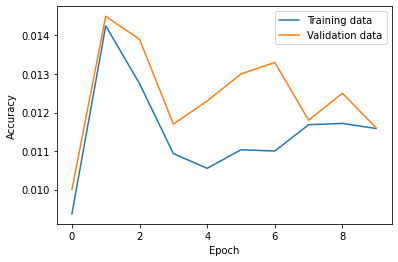

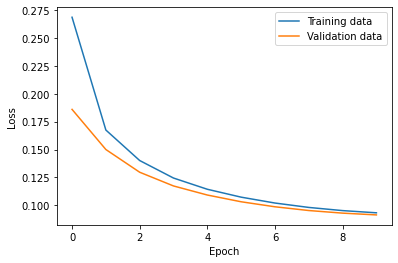

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning 

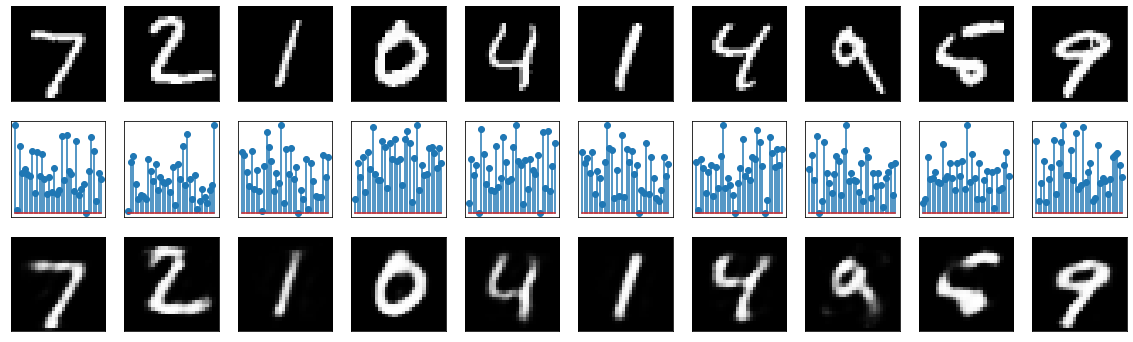

In [101]:
x_nodes = 784
z_dim = 36

autoencoder = FCAE(x_nodes, z_dim)

history = autoencoder.fit(x_train, x_train,
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

plot_acc(history)
plt.show()
plot_loss(history)
plt.show()

show_ae(autoencoder)
plt.show()

# Convolutional Auto Encoder

In [112]:
import tensorflow.keras as keras

In [102]:
def Conv2D(filters, kernel_size, padding='same', activation='relu'):
    return layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)

In [132]:
class ConvAE(models.Model):
    def __init__(self, org_shape=(1, 28, 28)):
        # Input
        original = layers.Input(shape=org_shape)

        # encoding-1
        x = Conv2D(4, (3, 3))(original)
        x = layers.MaxPool2D((2, 2), padding='same')(x)

        # encoding-2
        x = Conv2D(8, (3, 3))(x)
        x = layers.MaxPool2D((2, 2), padding='same')(x)

        # encoding-3
        z = Conv2D(1, (7, 7))(x)
        '''
        # decoding-1
        y = Conv2D(16, (3, 3))(z)
        y = layers.UpSampling2D((2, 2), y)

        # decoding-2
        y = Conv2D(8, (3, 3))(y)
        y = layers.UpSampling2D((2, 2), y)

        # decoding-3
        y = Conv2D(4, (3, 3))(y)

        # decoding & output
        decoded = Conv2D(1, (3, 3), activation='sigmoid')(y)

        super().__init__(original, decoded)
        self.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy'])
        '''

In [105]:
from tensorflow.keras import backend

In [106]:
# 합성곱 AE 결과 시각화
def show_ae(autoencoder, data):
    x_test = data.x_test
    decoded_imgs = autoencoder.predict(x_test)
    print(decoded_imgs.shape, data.x_test.shape)

    if backend.image_data_format() == 'channels_first':
        N, n_ch, n_i, n_j = x_test.shape
    else:
        N, n_i, n_j, n_ch = x_test.shape

    x_test = x_test.reshape(N, n_i, n_j)
    decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0], n_i, n_j)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [109]:
from tensorflow.keras import datasets

In [110]:
class DATA():
    def __init__(self):
        num_classes = 10

        (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
        img_rows, img_cols = x_train.shape[1:]

        if backend.image_data_format() == 'channels_first':
            print('image data format : channels_first')
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img.cols)
            input_shape = (1, img_rows, img_cols)
        else:
            print('image data format : channels_last')
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

        self.input_shape = input_shape
        self.num_classes = num_classes
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test

In [133]:
data = DATA()
print(data.input_shape)
autoencoder = ConvAE(data.input_shape)

history = autoencoder.fit(data.x_train, data.x_train,
                          epochs=20,
                          batch_size=128,
                          shuffle=True,
                          validation_split=0.2)

plot_acc(history)
plt.show()
plot_loss(history)
plt.show()

show_ae(autoencoder, data)
plt.show()

image data format : channels_last
(28, 28, 1)


AttributeError: ignored